# Task 1: Science Related Classification

This notebook implements a machine learning pipeline for classifying tweets as science-related or not.

## Setup

Import required libraries and configure warnings

In [17]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, make_scorer
)
import optuna
import emoji
import re
import scipy.sparse
import spacy
from langdetect import detect
import joblib
from sklearn.model_selection import cross_val_score

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


## ModelPipeline Class Definition

Pipeline for data processing and model training

In [24]:
class ModelPipeline:
    def __init__(self, name="ModelPipeline"):
        self.name = name
        self.models = {
            "Naïve Bayes": MultinomialNB(),
            "Random Forest": RandomForestClassifier(n_jobs=-1),
            "SVM": SVC(kernel='linear'),
            "KNN": KNeighborsClassifier(n_jobs=-1),
            "AdaBoost": AdaBoostClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
            "Neural Network - MLP": MLPClassifier(max_iter=300)
        }
        self.scorers = {
            "Accuracy": make_scorer(accuracy_score),
            "Precision": make_scorer(precision_score),
            "Recall": make_scorer(recall_score),
            "F1 Score": make_scorer(f1_score)
        }
        self.results = {}
        self.best_model = None
        self.vectorizer = None

    def preprocess_data(self, df, with_preprocessing=False):
        """Preprocess data based on the phase"""
        # Convert emojis
        df['text'] = df['text'].apply(lambda x: emoji.demojize(x))
        
        # Add binary features
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')
        
        if with_preprocessing:
            try:
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            except OSError:
                print("Installing spaCy models...")
                import os
                os.system("python -m spacy download fr_core_news_sm")
                os.system("python -m spacy download en_core_web_sm")
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            
            def clean_and_lemmatize_multilang(text):
                text = text.lower()
                text = re.sub(r"http\S+", "URL", text)
                text = re.sub(r"@\w+", "MENTION", text)
                text = re.sub(r"#(\w+)", r"\1", text)
                text = re.sub(r"[^\w\s:]", "", text)
                try:
                    lang = detect(text)
                except:
                    lang = "en"
                doc = nlp_fr(text) if lang == "fr" else nlp_en(text)
                return " ".join([token.lemma_ for token in doc if not token.is_stop])
            
            df['text_clean'] = df['text'].apply(clean_and_lemmatize_multilang)
            text_column = 'text_clean'
        else:
            text_column = 'text'

        return df, text_column

    def prepare_features(self, df, text_column, stopwords=None, max_features=10000):
        """Prepare feature matrix from preprocessed data"""
        vectorizer = TfidfVectorizer(
            min_df=5,
            max_df=0.95,
            stop_words=stopwords,
            lowercase=True,
            ngram_range=(1, 2),
            max_features=max_features
        ) if stopwords else TfidfVectorizer(max_features=max_features)
        
        X_text = df[text_column]
        X_tfidf = vectorizer.fit_transform(X_text)
        self.vectorizer = vectorizer
        
        # Binary features
        extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
        X_extra = scipy.sparse.csr_matrix(extra_features.values)
        
        # Combine features
        X_final = scipy.sparse.hstack([X_tfidf, X_extra])
        
        return X_final, vectorizer

    def train_and_evaluate(self, X, y, phase_name):
        """Train and evaluate models using k-fold cross-validation"""
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = []
        best_f1 = 0
        
        for name, model in self.models.items():
            print(f"\n🔍 Training model: {name}")
            
            fold_metrics = {
                "Accuracy": [],
                "Precision": [],
                "Recall": [],
                "F1": []
            }
            
            for fold, (train_idx, test_idx) in enumerate(cv.split(X.toarray() if scipy.sparse.issparse(X) else X, y), 1):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                fold_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
                fold_metrics["Precision"].append(precision_score(y_test, y_pred))
                fold_metrics["Recall"].append(recall_score(y_test, y_pred))
                fold_metrics["F1"].append(f1_score(y_test, y_pred))
                
                if fold == cv.n_splits:
                    plt.figure(figsize=(6, 5))
                    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
                    plt.title(f'Confusion Matrix - {name} ({phase_name})')
                    plt.xlabel('Predicted')
                    plt.ylabel('True')
                    plt.show()
            
            metrics = {
                "Model": name,
                "Phase": phase_name
            }
            
            for metric_name, scores in fold_metrics.items():
                metrics[metric_name] = np.mean(scores)
                metrics[f"{metric_name}_Std"] = np.std(scores)
                print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

            display(self.vectorizer)
            
            # Track best model
            if metrics["F1"] > best_f1:
                best_f1 = metrics["F1"]
                self.best_model = {
                    'name': name,
                    'model': model,
                    'vectorizer': self.vectorizer
                }
            
            results.append(metrics)
        
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'model_results_task1_{phase_name.lower().replace(" ", "_")}.csv', index=False)
        return results_df

    def save_best_model(self):
        """Save the best performing model"""
        if self.best_model is None:
            print("No best model found. Please run train_and_evaluate first.")
            return
        
        print(f"\nSaving best model: {self.best_model['name']}")
        joblib.dump(self.best_model, 'best_model_task1.joblib')
        print("Model saved successfully!")


    def optimize_mlp_with_optuna(self, X, y, n_trials=30):
        def objective(trial):
            hidden_layer_sizes = trial.suggest_categorical(
                "hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)]
            )
            learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    
            model = Pipeline([
                ("scaler", StandardScaler(with_mean=False)),
                ("mlp", MLPClassifier(
                    hidden_layer_sizes=hidden_layer_sizes,
                    learning_rate_init=learning_rate_init,
                    max_iter=500,
                    random_state=42
                ))
            ])
    
            # Cross-validation
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
            return scores.mean()

        print("🔧 Démarrage de l’optimisation Optuna (MLPClassifier)...")
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)
    
        print("\n✅ Résultat Optuna:")
        print("Meilleurs hyperparamètres :", study.best_params)
        print("Score moyen en cross-validation (accuracy):", round(study.best_value, 4))
        return study




## Data Loading

In [25]:
# Load data
print("Loading data...")
df = pd.read_csv('scitweets_balanced.tsv', sep='\t')
df.dropna(subset=['text'], inplace=True)
y = df['science_related']

# Display sample of the data
print("\nSample of the dataset:")
display(df.head())

# Initialize pipeline
pipeline = ModelPipeline()

Loading data...

Sample of the dataset:


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0.0,3.166700e+17,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1.0,3.190909e+17,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2.0,3.220309e+17,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3.0,3.226948e+17,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4.0,3.285244e+17,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


## Training and Evaluation

=== Training Model ===

🔍 Training model: Naïve Bayes


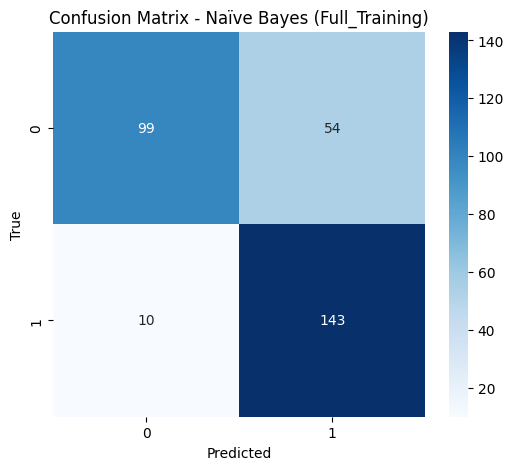

Accuracy: 0.8163 ± 0.0213
Precision: 0.7538 ± 0.0180
Recall: 0.9399 ± 0.0232
F1: 0.8365 ± 0.0189


TfidfVectorizer(max_features=10000)


🔍 Training model: Random Forest


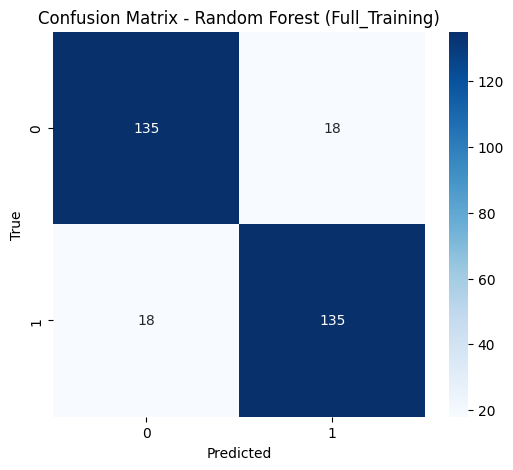

Accuracy: 0.8850 ± 0.0199
Precision: 0.8892 ± 0.0205
Recall: 0.8797 ± 0.0253
F1: 0.8843 ± 0.0203


TfidfVectorizer(max_features=10000)


🔍 Training model: SVM


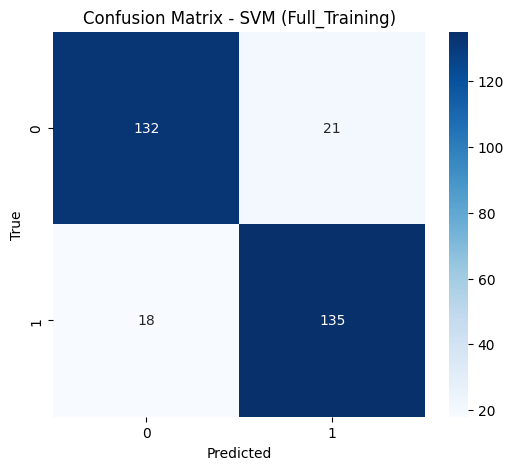

Accuracy: 0.8987 ± 0.0160
Precision: 0.9016 ± 0.0192
Recall: 0.8954 ± 0.0180
F1: 0.8984 ± 0.0158


TfidfVectorizer(max_features=10000)


🔍 Training model: KNN


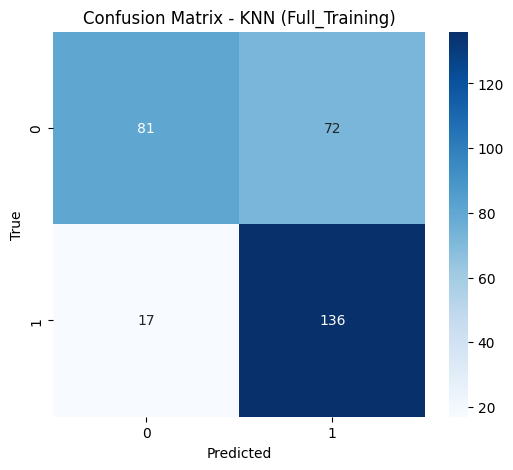

Accuracy: 0.7412 ± 0.0214
Precision: 0.6878 ± 0.0192
Recall: 0.8850 ± 0.0332
F1: 0.7736 ± 0.0186


TfidfVectorizer(max_features=10000)


🔍 Training model: AdaBoost


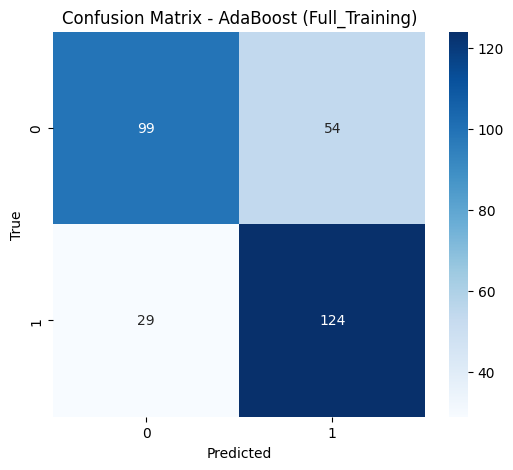

Accuracy: 0.7458 ± 0.0237
Precision: 0.7406 ± 0.0265
Recall: 0.7608 ± 0.0714
F1: 0.7481 ± 0.0332


TfidfVectorizer(max_features=10000)


🔍 Training model: XGBoost


/Users/salhinina/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:52:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/salhinina/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/salhinina/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/salhinina/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

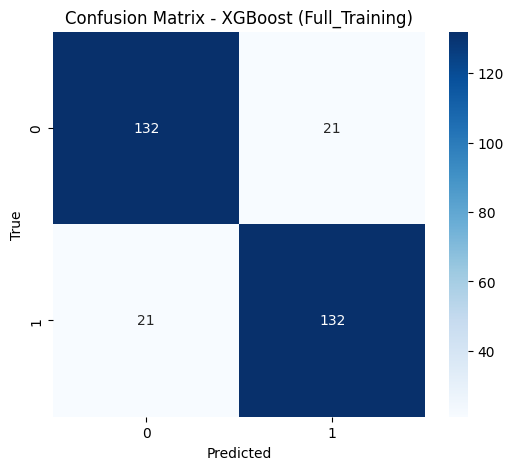

Accuracy: 0.8451 ± 0.0191
Precision: 0.8446 ± 0.0181
Recall: 0.8458 ± 0.0232
F1: 0.8451 ± 0.0195


TfidfVectorizer(max_features=10000)


🔍 Training model: Neural Network - MLP


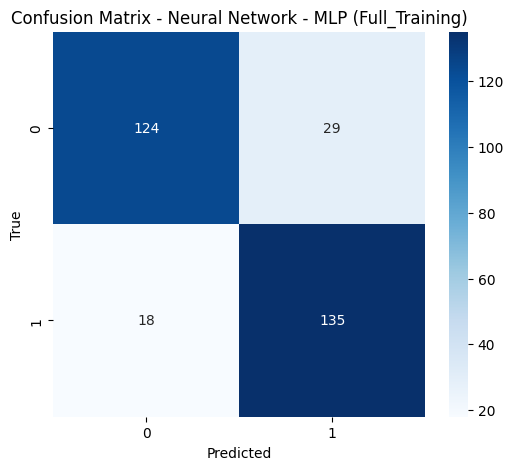

Accuracy: 0.9026 ± 0.0308
Precision: 0.8949 ± 0.0390
Recall: 0.9137 ± 0.0232
F1: 0.9040 ± 0.0290


TfidfVectorizer(max_features=10000)


Results:


,Model,Phase,Accuracy,Accuracy_Std,Precision,Precision_Std,Recall,Recall_Std,F1,F1_Std
0,Naïve Bayes,Full_Training,0.816340,0.021320,0.753788,0.018013,0.939869,0.023163,0.836535,0.018856
1,Random Forest,Full_Training,0.884967,0.019868,0.889180,0.020458,0.879739,0.025347,0.884296,0.020271
2,SVM,Full_Training,0.898693,0.016010,0.901561,0.019179,0.895425,0.018018,0.898374,0.015783
3,KNN,Full_Training,0.741176,0.021420,0.687789,0.019225,0.884967,0.033224,0.773636,0.018641
4,AdaBoost,Full_Training,0.745752,0.023692,0.740588,0.026514,0.760784,0.071430,0.748081,0.033157
5,XGBoost,Full_Training,0.845098,0.019123,0.844642,0.018080,0.845752,0.023237,0.845137,0.019535
6,Neural Network - MLP,Full_Training,0.902614,0.030823,0.894933,0.038993,0.913725,0.023163,0.903992,0.028995



Saving best model: Neural Network - MLP
Model saved successfully!


In [26]:
print("=== Training Model ===")
df_prepared, text_column = pipeline.preprocess_data(df.copy(), with_preprocessing=True)

# Load French stopwords
stopwords_df = pd.read_csv("StopWordsFrench.csv", sep=',', index_col=0)
french_stopwords = stopwords_df.index.tolist()

X_prepared, _ = pipeline.prepare_features(df_prepared, text_column, french_stopwords)
results = pipeline.train_and_evaluate(X_prepared, y, "Full_Training")

print("\nResults:")
display(results)

# Save the best model
pipeline.save_best_model()

## Results Visualization

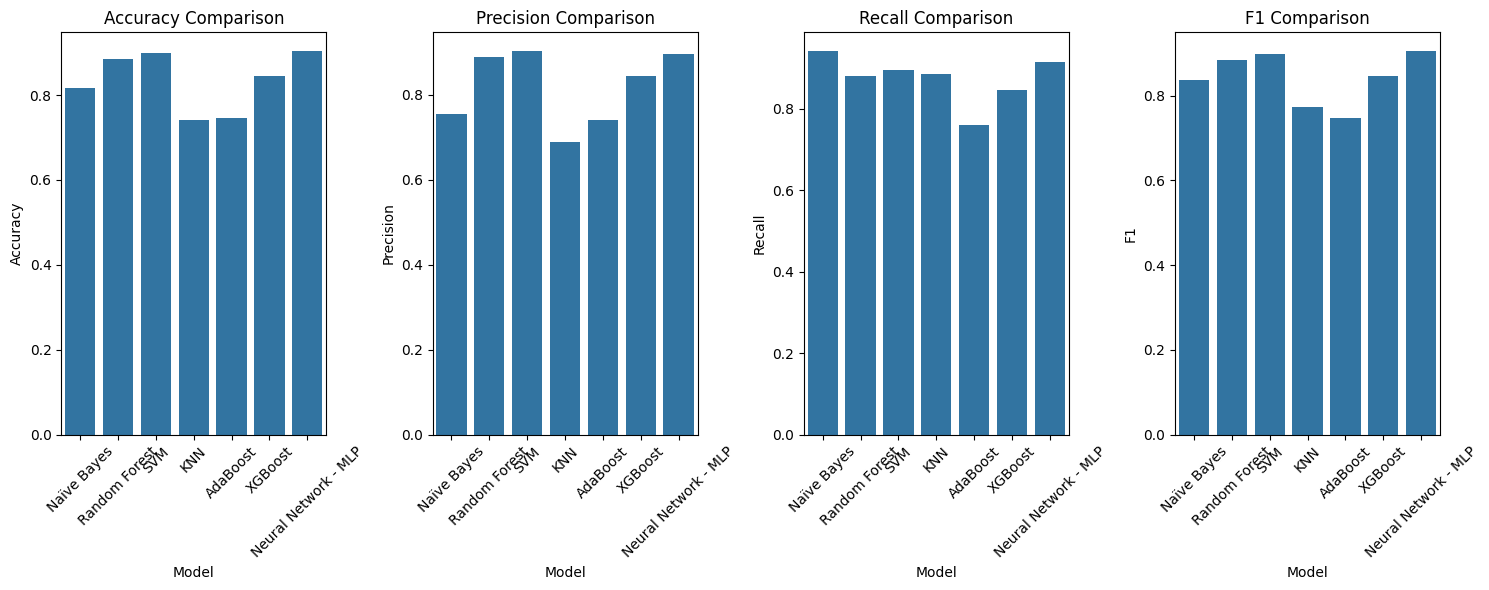

In [27]:
# Plot comparison
plt.figure(figsize=(15, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=results, x='Model', y=metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

## optuna test 

In [28]:
study = pipeline.optimize_mlp_with_optuna(X_prepared, y, n_trials=30)


[I 2025-05-04 21:53:43,558] A new study created in memory with name: no-name-44cc0437-6fca-45db-afac-ebdfe2e50854


🔧 Démarrage de l’optimisation Optuna (MLPClassifier)...


/Users/salhinina/mon_env/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/Users/salhinina/mon_env/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/Users/salhinina/mon_env/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
/Users/salhinina/mon_env/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, 


✅ Résultat Optuna:
Meilleurs hyperparamètres : {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.006539316377973775}
Score moyen en cross-validation (accuracy): 0.8778
